In [1]:
# Install XGBoost
!pip install xgboost

print("✓ XGBoost installed successfully!")

✓ XGBoost installed successfully!


## Import Librarys and Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score
)
import time
import warnings
warnings.filterwarnings('ignore')

# Set style for nice plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*80)
print("XGBoost MODEL TRAINING PIPELINE")
print("Stock Outperformance Prediction")
print("="*80)

print("\n" + "="*80)
print("STEP 1: Loading ML-Ready Dataset")
print("="*80)

# Load the dataset
df = pd.read_csv('ml_ready_dataset.csv')

print(f"\n✓ Dataset loaded successfully")
print(f"  Shape: {df.shape}")
print(f"  Columns: {len(df.columns)}")
print(f"  Date range: {df['Date'].min()} to {df['Date'].max()}")

# Display basic info
print(f"\n✓ Stocks in dataset:")
print(df['stock'].value_counts())

print(f"\n✓ Target variable distribution:")
print(df['y'].value_counts())
print("\nClass balance:")
class_balance = df['y'].value_counts(normalize=True)
print(class_balance)

# Check for missing values
print(f"\n✓ Missing values:")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("  No missing values ✓")
else:
    print(missing[missing > 0])

# Display first few rows
print(f"\n✓ First 5 rows:")
print(df.head())

XGBoost MODEL TRAINING PIPELINE
Stock Outperformance Prediction

STEP 1: Loading ML-Ready Dataset

✓ Dataset loaded successfully
  Shape: (8594, 33)
  Columns: 33
  Date range: 2004-11-17 to 2025-10-31

✓ Stocks in dataset:
stock
GOOGL    5273
META     3321
Name: count, dtype: int64

✓ Target variable distribution:
y
1    4839
0    3755
Name: count, dtype: int64

Class balance:
y
1    0.563067
0    0.436933
Name: proportion, dtype: float64

✓ Missing values:
  No missing values ✓

✓ First 5 rows:
         Date  stock  daily_return      r_1W      r_1M      r_3M    vol_1M  \
0  2004-11-17  GOOGL     -0.000232  0.027642  0.166013  0.719155  0.055914   
1  2004-11-18  GOOGL     -0.028754 -0.084581  0.192541  0.546857  0.054962   
2  2004-11-19  GOOGL      0.011102 -0.069231  0.134021  0.548446  0.053586   
3  2004-11-22  GOOGL     -0.025384 -0.106940 -0.042510  0.574330  0.042047   
4  2004-11-23  GOOGL      0.014658 -0.029095 -0.106083  0.580377  0.037156   

   MA20_ratio  MA50_ratio  HL

## Prepare Features and Target

In [3]:
print("\n" + "="*80)
print("STEP 2: Preparing Features and Target")
print("="*80)

# Identify columns to exclude from features
exclude_cols = [
    'Date',      # Not a feature (time index)
    'stock',     # Not a feature (categorical identifier)
    'y'          # Target variable
]

# Remove columns that might not exist
exclude_cols = [col for col in exclude_cols if col in df.columns]

# Create feature matrix (X) and target vector (y)
X = df.drop(columns=exclude_cols)
y = df['y']

print(f"\n✓ Feature matrix (X) shape: {X.shape}")
print(f"✓ Target vector (y) shape: {y.shape}")

print(f"\n✓ Features being used ({len(X.columns)}):")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:2d}. {col}")

# Check for any remaining non-numeric columns
non_numeric = X.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric:
    print(f"\n⚠️  Warning: Non-numeric columns found: {non_numeric}")
    print("   Dropping these columns...")
    X = X.select_dtypes(include=[np.number])
    print(f"   New shape: {X.shape}")

# Store feature names for later use
feature_names = X.columns.tolist()
print(f"\n✓ Final feature count: {len(feature_names)}")


STEP 2: Preparing Features and Target

✓ Feature matrix (X) shape: (8594, 30)
✓ Target vector (y) shape: (8594,)

✓ Features being used (30):
   1. daily_return
   2. r_1W
   3. r_1M
   4. r_3M
   5. vol_1M
   6. MA20_ratio
   7. MA50_ratio
   8. HL_range
   9. vol_z
  10. sp500_daily_return
  11. sp500_vol_1M
  12. relative_return
  13. volatility_ratio
  14. VIX_t
  15. FedFunds_t
  16. CPI_chg
  17. FedFunds_chg
  18. Put_Call_Ratio_t
  19. Market_Breadth_t
  20. spy_RSI_t
  21. spy_SMA_50_t
  22. spy_SMA_200_t
  23. qqq_RSI_t
  24. qqq_SMA_50_t
  25. qqq_SMA_200_t
  26. sector_XLK_t
  27. sector_XLF_t
  28. sector_XLV_t
  29. sector_XLE_t
  30. sector_XLI_t

✓ Final feature count: 30


## Chronological Train-Test Split

In [4]:
print("\n" + "="*80)
print("STEP 3: Chronological Train-Test Split (80/20)")
print("="*80)

# Important: Use shuffle=False for time-series data!
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 20% for testing
    shuffle=False,      # CRITICAL: Maintain temporal order
    random_state=42
)

print(f"\n✓ Training set:")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  Class distribution:")
print(f"    Class 0 (Underperform): {(y_train == 0).sum()} ({(y_train == 0).sum()/len(y_train)*100:.1f}%)")
print(f"    Class 1 (Outperform):   {(y_train == 1).sum()} ({(y_train == 1).sum()/len(y_train)*100:.1f}%)")

print(f"\n✓ Test set:")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")
print(f"  Class distribution:")
print(f"    Class 0 (Underperform): {(y_test == 0).sum()} ({(y_test == 0).sum()/len(y_test)*100:.1f}%)")
print(f"    Class 1 (Outperform):   {(y_test == 1).sum()} ({(y_test == 1).sum()/len(y_test)*100:.1f}%)")

# Verify chronological split
if 'Date' in df.columns:
    dates = df['Date']
    train_dates = dates.iloc[:len(X_train)]
    test_dates = dates.iloc[len(X_train):]

    print(f"\n✓ Temporal split verification:")
    print(f"  Train period: {train_dates.min()} to {train_dates.max()}")
    print(f"  Test period:  {test_dates.min()} to {test_dates.max()}")


STEP 3: Chronological Train-Test Split (80/20)

✓ Training set:
  X_train shape: (6875, 30)
  y_train shape: (6875,)
  Class distribution:
    Class 0 (Underperform): 2987 (43.4%)
    Class 1 (Outperform):   3888 (56.6%)

✓ Test set:
  X_test shape: (1719, 30)
  y_test shape: (1719,)
  Class distribution:
    Class 0 (Underperform): 768 (44.7%)
    Class 1 (Outperform):   951 (55.3%)

✓ Temporal split verification:
  Train period: 2004-11-17 to 2025-10-31
  Test period:  2019-01-02 to 2025-10-31


## Train XGBoost Model

In [5]:
print("\n" + "="*80)
print("STEP 4: Training XGBoost Model (Basic Configuration)")
print("="*80)

# Calculate scale_pos_weight for class imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Initialize XGBoost Classifier with reasonable defaults
xgb_model_basic = xgb.XGBClassifier(
    n_estimators=100,           # Number of boosting rounds
    max_depth=6,                # Maximum tree depth
    learning_rate=0.1,          # Step size shrinkage
    subsample=0.8,              # Subsample ratio of training data
    colsample_bytree=0.8,       # Subsample ratio of columns
    scale_pos_weight=scale_pos_weight,  # Handle class imbalance
    random_state=42,
    eval_metric='logloss',      # Evaluation metric
    n_jobs=-1                   # Use all CPU cores
)

print("\n✓ Model configuration:")
print(f"  Algorithm: XGBoost (Gradient Boosting)")
print(f"  Number of trees: {xgb_model_basic.n_estimators}")
print(f"  Max depth: {xgb_model_basic.max_depth}")
print(f"  Learning rate: {xgb_model_basic.learning_rate}")
print(f"  Subsample: {xgb_model_basic.subsample}")
print(f"  Column sample: {xgb_model_basic.colsample_bytree}")
print(f"  Scale pos weight: {scale_pos_weight:.4f} (for class imbalance)")

# Train the model with early stopping
print("\n✓ Training model...")
start_time = time.time()

xgb_model_basic.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds")

# Make predictions
print("\n✓ Generating predictions...")
y_train_pred = xgb_model_basic.predict(X_train)
y_test_pred = xgb_model_basic.predict(X_test)

# Get prediction probabilities
y_train_proba = xgb_model_basic.predict_proba(X_train)[:, 1]
y_test_proba = xgb_model_basic.predict_proba(X_test)[:, 1]

print("✓ Predictions generated for train and test sets")


STEP 4: Training XGBoost Model (Basic Configuration)

✓ Model configuration:
  Algorithm: XGBoost (Gradient Boosting)
  Number of trees: 100
  Max depth: 6
  Learning rate: 0.1
  Subsample: 0.8
  Column sample: 0.8
  Scale pos weight: 0.7683 (for class imbalance)

✓ Training model...
✓ Training completed in 2.62 seconds

✓ Generating predictions...
✓ Predictions generated for train and test sets


## Evaluate Basic Model Performance

In [6]:
print("\n" + "="*80)
print("STEP 5: Basic Model Performance Evaluation")
print("="*80)

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_test_pred)

train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

# Display results
print("\n" + "="*80)
print("BASIC XGBOOST MODEL - PERFORMANCE METRICS")
print("="*80)

print("\n📊 TRAINING SET PERFORMANCE:")
print(f"  Accuracy:  {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"  Precision: {train_precision:.4f}")
print(f"  Recall:    {train_recall:.4f}")
print(f"  F1-Score:  {train_f1:.4f}")
print(f"  ROC-AUC:   {train_auc:.4f}")

print("\n📊 TEST SET PERFORMANCE:")
print(f"  Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")
print(f"  ROC-AUC:   {test_auc:.4f}")

# Check for overfitting
accuracy_diff = train_accuracy - test_accuracy
print("\n📈 OVERFITTING CHECK:")
print(f"  Train-Test Accuracy Gap: {accuracy_diff:.4f} ({accuracy_diff*100:.2f}%)")
if accuracy_diff < 0.05:
    print("  ✓ Model generalizes well (low overfitting)")
elif accuracy_diff < 0.10:
    print("  ⚠️  Moderate overfitting detected")
else:
    print("  ❌ High overfitting - model is memorizing training data")

# Detailed classification report
print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORT (TEST SET)")
print("="*80)
print(classification_report(y_test, y_test_pred,
                          target_names=['Underperform (0)', 'Outperform (1)']))

# Comparison to Logistic Regression
print("\n📊 COMPARISON TO BASELINE (Logistic Regression):")
print(f"  Logistic Regression Accuracy: 51.25%")
print(f"  XGBoost Accuracy:             {test_accuracy*100:.2f}%")
print(f"  Improvement:                  {(test_accuracy - 0.5125)*100:+.2f}%")
if test_accuracy > 0.5125:
    print("  ✓ XGBoost outperforms baseline!")
else:
    print("  ⚠️  XGBoost underperforms baseline")


STEP 5: Basic Model Performance Evaluation

BASIC XGBOOST MODEL - PERFORMANCE METRICS

📊 TRAINING SET PERFORMANCE:
  Accuracy:  0.9491 (94.91%)
  Precision: 0.9569
  Recall:    0.9529
  F1-Score:  0.9549
  ROC-AUC:   0.9909

📊 TEST SET PERFORMANCE:
  Accuracy:  0.5212 (52.12%)
  Precision: 0.5780
  Recall:    0.4984
  F1-Score:  0.5353
  ROC-AUC:   0.5514

📈 OVERFITTING CHECK:
  Train-Test Accuracy Gap: 0.4279 (42.79%)
  ❌ High overfitting - model is memorizing training data

DETAILED CLASSIFICATION REPORT (TEST SET)
                  precision    recall  f1-score   support

Underperform (0)       0.47      0.55      0.51       768
  Outperform (1)       0.58      0.50      0.54       951

        accuracy                           0.52      1719
       macro avg       0.52      0.52      0.52      1719
    weighted avg       0.53      0.52      0.52      1719


📊 COMPARISON TO BASELINE (Logistic Regression):
  Logistic Regression Accuracy: 51.25%
  XGBoost Accuracy:             52.12

## Hyperparameter Tuning

In [7]:
print("\n" + "="*80)
print("STEP 6: Hyperparameter Tuning (GridSearchCV)")
print("="*80)
print("\n⚠️  This may take 5-10 minutes...")

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

print(f"\n✓ Parameter grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")
print(f"\n  Total combinations: {np.prod([len(v) for v in param_grid.values()])}")

# Initialize base model
xgb_base = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

# Grid search with cross-validation
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=3,                    # 3-fold cross-validation
    scoring='accuracy',      # Optimize for accuracy
    n_jobs=-1,              # Use all cores
    verbose=1
)

print("\n✓ Starting grid search...")
start_time = time.time()

grid_search.fit(X_train, y_train)

tuning_time = time.time() - start_time
print(f"\n✓ Grid search completed in {tuning_time:.2f} seconds ({tuning_time/60:.1f} minutes)")

# Best parameters
print("\n" + "="*80)
print("BEST HYPERPARAMETERS FOUND:")
print("="*80)
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\n✓ Best cross-validation score: {grid_search.best_score_:.4f}")

# Train final model with best parameters
print("\n✓ Training final model with best parameters...")
xgb_model_tuned = grid_search.best_estimator_

# Make predictions with tuned model
y_train_pred_tuned = xgb_model_tuned.predict(X_train)
y_test_pred_tuned = xgb_model_tuned.predict(X_test)
y_train_proba_tuned = xgb_model_tuned.predict_proba(X_train)[:, 1]
y_test_proba_tuned = xgb_model_tuned.predict_proba(X_test)[:, 1]

# Evaluate tuned model
test_accuracy_tuned = accuracy_score(y_test, y_test_pred_tuned)
test_f1_tuned = f1_score(y_test, y_test_pred_tuned)
test_auc_tuned = roc_auc_score(y_test, y_test_proba_tuned)

print("\n" + "="*80)
print("TUNED MODEL PERFORMANCE")
print("="*80)
print(f"  Accuracy:  {test_accuracy_tuned:.4f} ({test_accuracy_tuned*100:.2f}%)")
print(f"  F1-Score:  {test_f1_tuned:.4f}")
print(f"  ROC-AUC:   {test_auc_tuned:.4f}")

print("\n📊 IMPROVEMENT FROM TUNING:")
print(f"  Basic XGBoost Accuracy: {test_accuracy*100:.2f}%")
print(f"  Tuned XGBoost Accuracy: {test_accuracy_tuned*100:.2f}%")
print(f"  Improvement:            {(test_accuracy_tuned - test_accuracy)*100:+.2f}%")

# Use tuned model for rest of analysis
xgb_model_final = xgb_model_tuned
y_test_pred_final = y_test_pred_tuned
y_test_proba_final = y_test_proba_tuned
test_accuracy_final = test_accuracy_tuned
test_f1_final = test_f1_tuned
test_auc_final = test_auc_tuned


STEP 6: Hyperparameter Tuning (GridSearchCV)

⚠️  This may take 5-10 minutes...

✓ Parameter grid:
  n_estimators: [100, 200, 300]
  max_depth: [4, 6, 8]
  learning_rate: [0.01, 0.05, 0.1]
  subsample: [0.8, 1.0]
  colsample_bytree: [0.8, 1.0]

  Total combinations: 108

✓ Starting grid search...
Fitting 3 folds for each of 108 candidates, totalling 324 fits

✓ Grid search completed in 405.25 seconds (6.8 minutes)

BEST HYPERPARAMETERS FOUND:
  colsample_bytree: 0.8
  learning_rate: 0.05
  max_depth: 8
  n_estimators: 200
  subsample: 0.8

✓ Best cross-validation score: 0.5473

✓ Training final model with best parameters...

TUNED MODEL PERFORMANCE
  Accuracy:  0.5055 (50.55%)
  F1-Score:  0.5335
  ROC-AUC:   0.5313

📊 IMPROVEMENT FROM TUNING:
  Basic XGBoost Accuracy: 52.12%
  Tuned XGBoost Accuracy: 50.55%
  Improvement:            -1.57%


## Confusion Matrix


STEP 7: Confusion Matrix Visualization


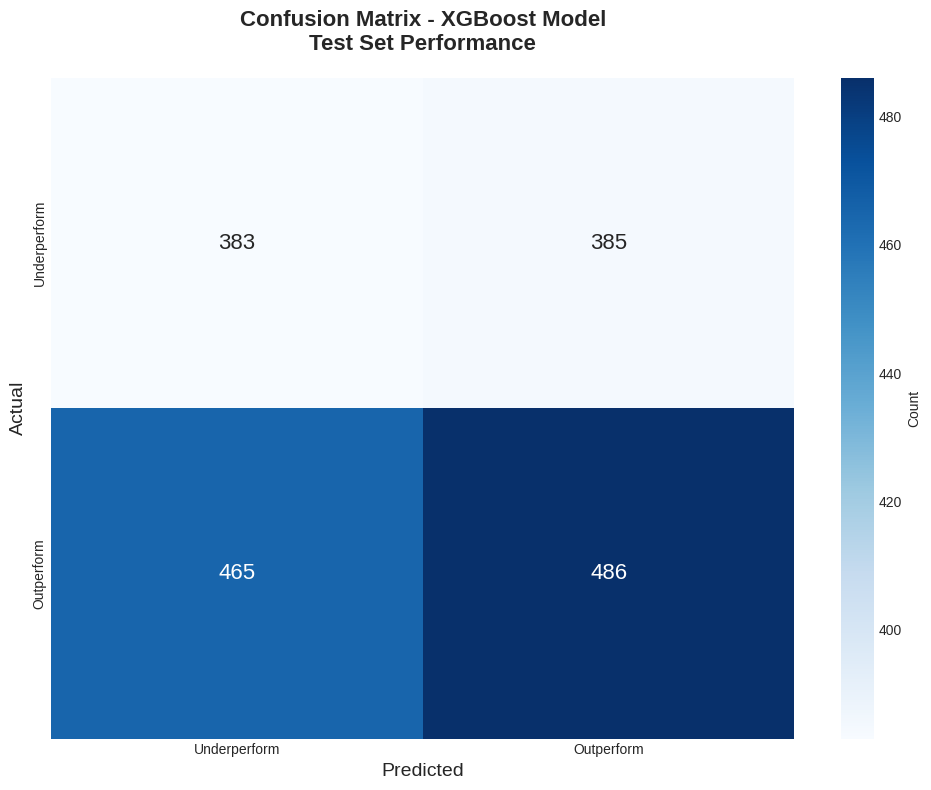

✓ Confusion matrix saved as 'xgboost_confusion_matrix.png'

📊 CONFUSION MATRIX BREAKDOWN:
  True Negatives (TN):   383 - Correctly predicted underperform
  False Positives (FP):  385 - Wrongly predicted outperform
  False Negatives (FN):  465 - Wrongly predicted underperform
  True Positives (TP):   486 - Correctly predicted outperform

  True Negative Rate:  49.9%
  True Positive Rate:  51.1%


In [8]:
print("\n" + "="*80)
print("STEP 7: Confusion Matrix Visualization")
print("="*80)

# Calculate confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred_final)

# Create confusion matrix plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Underperform', 'Outperform'],
            yticklabels=['Underperform', 'Outperform'],
            ax=ax, cbar_kws={'label': 'Count'}, annot_kws={'size': 16})

ax.set_title('Confusion Matrix - XGBoost Model\nTest Set Performance',
             fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Actual', fontsize=14)
ax.set_xlabel('Predicted', fontsize=14)

plt.tight_layout()
plt.savefig('xgboost_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved as 'xgboost_confusion_matrix.png'")

# Explain confusion matrix
print("\n📊 CONFUSION MATRIX BREAKDOWN:")
print(f"  True Negatives (TN):  {cm_test[0,0]:4d} - Correctly predicted underperform")
print(f"  False Positives (FP): {cm_test[0,1]:4d} - Wrongly predicted outperform")
print(f"  False Negatives (FN): {cm_test[1,0]:4d} - Wrongly predicted underperform")
print(f"  True Positives (TP):  {cm_test[1,1]:4d} - Correctly predicted outperform")

print(f"\n  True Negative Rate:  {cm_test[0,0]/(cm_test[0,0]+cm_test[0,1])*100:.1f}%")
print(f"  True Positive Rate:  {cm_test[1,1]/(cm_test[1,0]+cm_test[1,1])*100:.1f}%")

## ROC Curve Analysis


STEP 8: ROC Curve Analysis


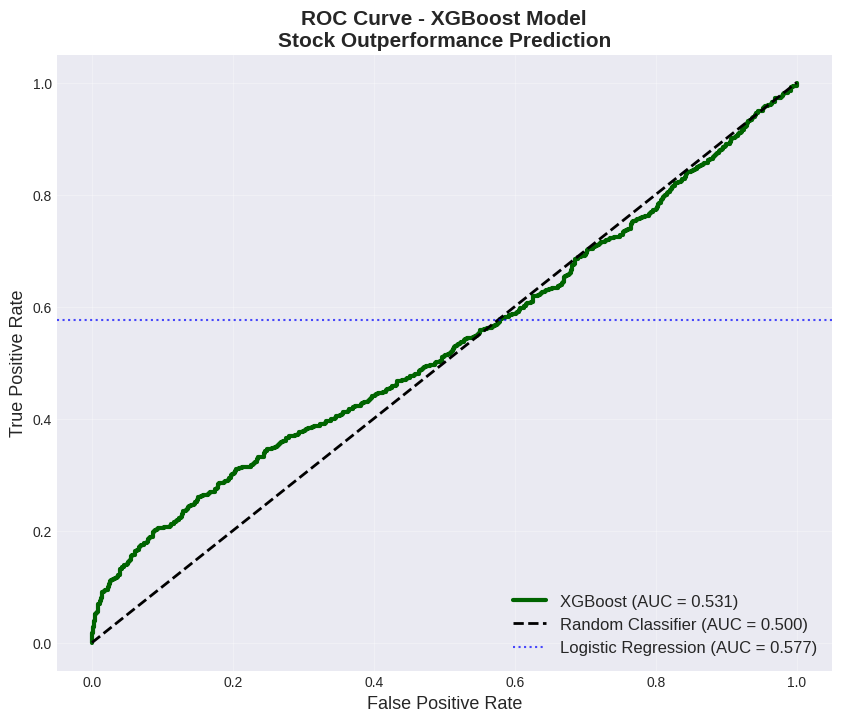

✓ ROC curve saved as 'xgboost_roc_curve.png'

📊 ROC-AUC INTERPRETATION:
  ⚠️  Fair: AUC = 0.531 (Weak but better than random)


In [9]:
print("\n" + "="*80)
print("STEP 8: ROC Curve Analysis")
print("="*80)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba_final)

# Plot ROC curve
plt.figure(figsize=(10, 8))

plt.plot(fpr, tpr, label=f'XGBoost (AUC = {test_auc_final:.3f})',
         linewidth=3, color='darkgreen')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.500)', linewidth=2)

# Add baseline comparison
plt.axhline(y=0.5768, color='blue', linestyle=':', alpha=0.7,
            label='Logistic Regression (AUC = 0.577)')

plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('ROC Curve - XGBoost Model\nStock Outperformance Prediction',
          fontsize=15, fontweight='bold')
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, alpha=0.3)

plt.savefig('xgboost_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ ROC curve saved as 'xgboost_roc_curve.png'")

print("\n📊 ROC-AUC INTERPRETATION:")
if test_auc_final > 0.7:
    print(f"  ✓ Excellent: AUC = {test_auc_final:.3f} (Strong predictive power)")
elif test_auc_final > 0.6:
    print(f"  ✓ Good: AUC = {test_auc_final:.3f} (Moderate predictive power)")
elif test_auc_final > 0.5:
    print(f"  ⚠️  Fair: AUC = {test_auc_final:.3f} (Weak but better than random)")
else:
    print(f"  ❌ Poor: AUC = {test_auc_final:.3f} (No better than random)")

## Feature Importance Analysis


STEP 9: Feature Importance Analysis

📊 TOP 15 MOST IMPORTANT FEATURES (Gain-based):
25. qqq_SMA_200_t                  | Importance: 0.0762
24. qqq_SMA_50_t                   | Importance: 0.0574
22. spy_SMA_200_t                  | Importance: 0.0564
21. spy_SMA_50_t                   | Importance: 0.0555
28. sector_XLV_t                   | Importance: 0.0487
15. FedFunds_t                     | Importance: 0.0423
26. sector_XLK_t                   | Importance: 0.0404
30. sector_XLI_t                   | Importance: 0.0402
19. Market_Breadth_t               | Importance: 0.0387
 7. MA50_ratio                     | Importance: 0.0377
27. sector_XLF_t                   | Importance: 0.0375
 5. vol_1M                         | Importance: 0.0372
29. sector_XLE_t                   | Importance: 0.0365
 4. r_3M                           | Importance: 0.0336
13. volatility_ratio               | Importance: 0.0332


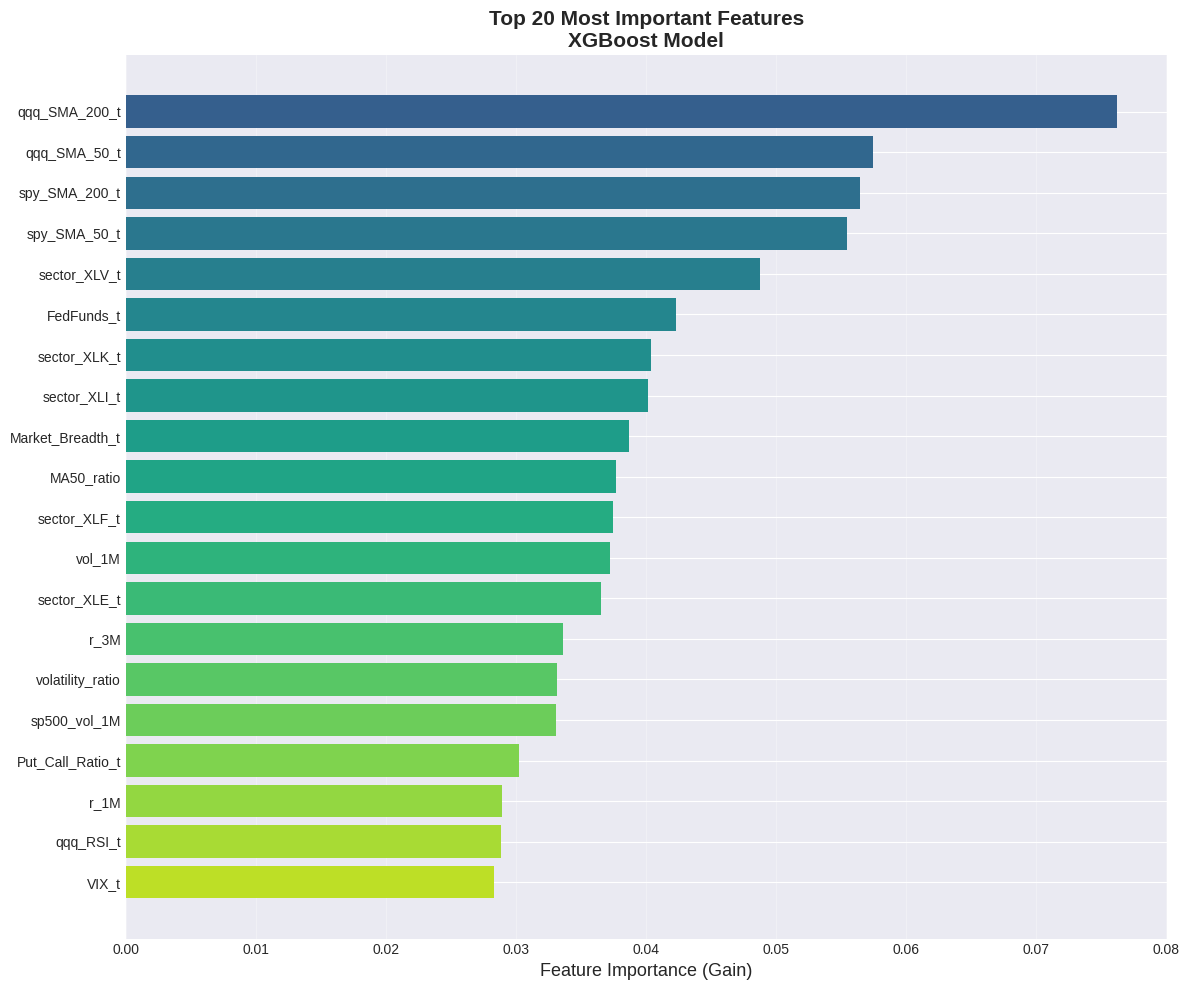


✓ Feature importance chart saved as 'xgboost_feature_importance.png'
✓ Feature importance data saved as 'xgboost_feature_importance.csv'

📊 COMPARISON TO LOGISTIC REGRESSION TOP FEATURES:
  Logistic Regression: sector_XLF_t, sector_XLI_t, volatility_ratio
  XGBoost:             qqq_SMA_200_t, qqq_SMA_50_t, spy_SMA_200_t


In [10]:
print("\n" + "="*80)
print("STEP 9: Feature Importance Analysis")
print("="*80)

# Get feature importance (gain-based)
importance_gain = xgb_model_final.feature_importances_

# Create dataframe
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_gain
}).sort_values('Importance', ascending=False)

print("\n📊 TOP 15 MOST IMPORTANT FEATURES (Gain-based):")
print("="*80)
for i, row in feature_importance_df.head(15).iterrows():
    print(f"{i+1:2d}. {row['Feature']:30s} | Importance: {row['Importance']:.4f}")

# Visualize top 20 features
plt.figure(figsize=(12, 10))
top_features = feature_importance_df.head(20)

colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_features)))
plt.barh(range(len(top_features)), top_features['Importance'], color=colors)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance (Gain)', fontsize=13)
plt.title('Top 20 Most Important Features\nXGBoost Model',
          fontsize=15, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

plt.savefig('xgboost_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Feature importance chart saved as 'xgboost_feature_importance.png'")

# Save feature importance to CSV
feature_importance_df.to_csv('xgboost_feature_importance.csv', index=False)
print("✓ Feature importance data saved as 'xgboost_feature_importance.csv'")

# Compare top features to Logistic Regression
print("\n📊 COMPARISON TO LOGISTIC REGRESSION TOP FEATURES:")
print("  Logistic Regression: sector_XLF_t, sector_XLI_t, volatility_ratio")
print(f"  XGBoost:             {', '.join(feature_importance_df.head(3)['Feature'].tolist())}")

## Learning Curves (Training Progress)


STEP 10: Model Analysis (Skipping Learning Curves)

⚠️  Learning curves not available with GridSearchCV tuning.
   (GridSearchCV doesn't store iteration-by-iteration training history)

✓  Alternative: Cross-validation scores show model stability


📊 CROSS-VALIDATION RESULTS:
  Best CV Score: 0.5473
  Std Deviation: 0.0195

📊 TOP 5 PARAMETER COMBINATIONS:
 param_n_estimators  param_max_depth  param_learning_rate  mean_test_score  std_test_score
                200                8                 0.05         0.547349        0.019514
                300                6                 0.05         0.547347        0.007797
                300                8                 0.05         0.547202        0.012343
                200                6                 0.05         0.546766        0.011156
                200                8                 0.05         0.546620        0.012052


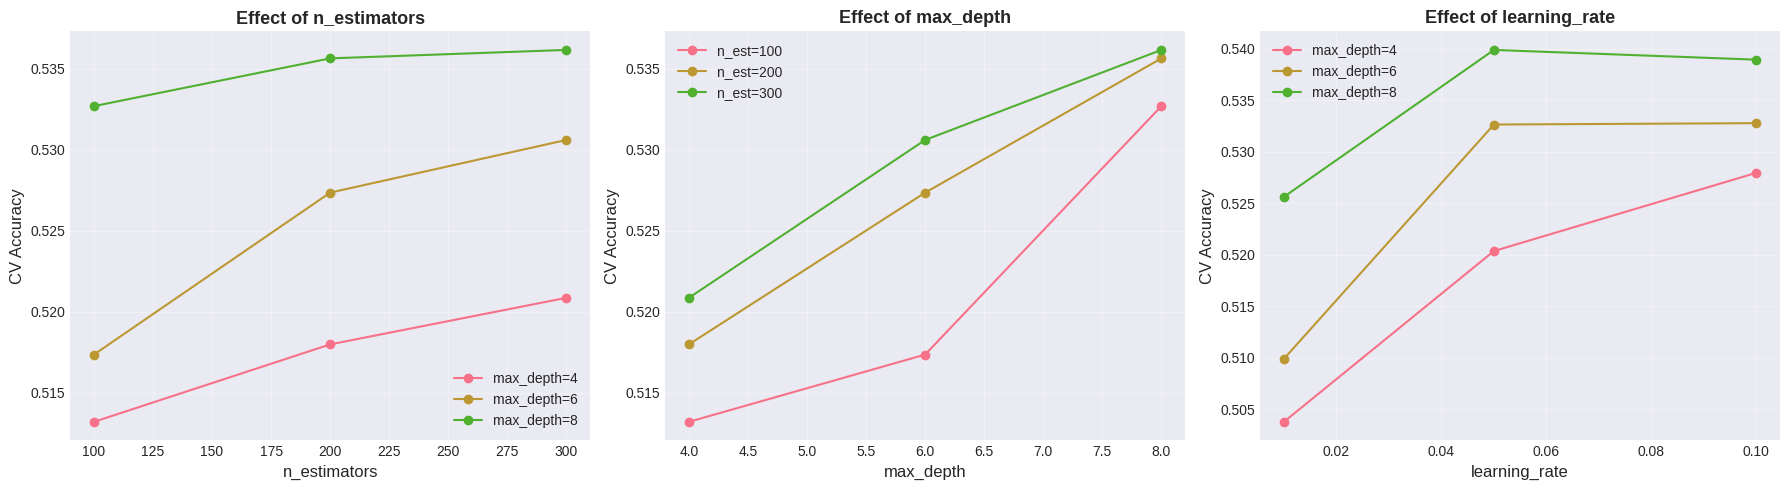


✓ Hyperparameter analysis saved as 'xgboost_hyperparameter_effects.png'

Proceeding to final summary...


In [12]:
print("\n" + "="*80)
print("STEP 10: Model Analysis (Skipping Learning Curves)")
print("="*80)

print("""
⚠️  Learning curves not available with GridSearchCV tuning.
   (GridSearchCV doesn't store iteration-by-iteration training history)

✓  Alternative: Cross-validation scores show model stability
""")

# Show cross-validation results instead
if hasattr(grid_search, 'cv_results_'):
    cv_results = pd.DataFrame(grid_search.cv_results_)

    print("\n📊 CROSS-VALIDATION RESULTS:")
    print(f"  Best CV Score: {grid_search.best_score_:.4f}")
    print(f"  Std Deviation: {cv_results.loc[grid_search.best_index_, 'std_test_score']:.4f}")

    # Show top 5 parameter combinations
    print("\n📊 TOP 5 PARAMETER COMBINATIONS:")
    top_5 = cv_results.nsmallest(5, 'rank_test_score')[
        ['param_n_estimators', 'param_max_depth', 'param_learning_rate',
         'mean_test_score', 'std_test_score']
    ]
    print(top_5.to_string(index=False))

    # Visualize parameter importance
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # n_estimators vs score
    for depth in param_grid['max_depth']:
        mask = cv_results['param_max_depth'] == depth
        data = cv_results[mask].groupby('param_n_estimators')['mean_test_score'].mean()
        axes[0].plot(data.index, data.values, marker='o', label=f'max_depth={depth}')
    axes[0].set_xlabel('n_estimators', fontsize=12)
    axes[0].set_ylabel('CV Accuracy', fontsize=12)
    axes[0].set_title('Effect of n_estimators', fontsize=13, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # max_depth vs score
    for n_est in param_grid['n_estimators']:
        mask = cv_results['param_n_estimators'] == n_est
        data = cv_results[mask].groupby('param_max_depth')['mean_test_score'].mean()
        axes[1].plot(data.index, data.values, marker='o', label=f'n_est={n_est}')
    axes[1].set_xlabel('max_depth', fontsize=12)
    axes[1].set_ylabel('CV Accuracy', fontsize=12)
    axes[1].set_title('Effect of max_depth', fontsize=13, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # learning_rate vs score
    for depth in param_grid['max_depth']:
        mask = cv_results['param_max_depth'] == depth
        data = cv_results[mask].groupby('param_learning_rate')['mean_test_score'].mean()
        axes[2].plot(data.index, data.values, marker='o', label=f'max_depth={depth}')
    axes[2].set_xlabel('learning_rate', fontsize=12)
    axes[2].set_ylabel('CV Accuracy', fontsize=12)
    axes[2].set_title('Effect of learning_rate', fontsize=13, fontweight='bold')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('xgboost_hyperparameter_effects.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n✓ Hyperparameter analysis saved as 'xgboost_hyperparameter_effects.png'")
else:
    print("\n⚠️  No GridSearchCV results available")

print("\n" + "="*80)
print("Proceeding to final summary...")
print("="*80)

## Final Summary Report

In [13]:
print("\n" + "="*80)
print("FINAL SUMMARY REPORT: XGBOOST MODEL")
print("="*80)

print(f"""
📊 DATASET SUMMARY:
  • Total observations: {len(df)}
  • Training samples: {len(X_train)} ({len(X_train)/len(df)*100:.1f}%)
  • Test samples: {len(X_test)} ({len(X_test)/len(df)*100:.1f}%)
  • Number of features: {X.shape[1]}
  • Target: Binary (0=Underperform, 1=Outperform S&P 500)

🎯 XGBOOST MODEL PERFORMANCE (TEST SET):
  • Accuracy: {test_accuracy_final:.4f} ({test_accuracy_final*100:.2f}%)
  • Precision: {precision_score(y_test, y_test_pred_final):.4f}
  • Recall: {recall_score(y_test, y_test_pred_final):.4f}
  • F1-Score: {test_f1_final:.4f}
  • ROC-AUC: {test_auc_final:.4f}

📈 BEST HYPERPARAMETERS:
  • n_estimators: {xgb_model_final.n_estimators}
  • max_depth: {xgb_model_final.max_depth}
  • learning_rate: {xgb_model_final.learning_rate}
  • subsample: {xgb_model_final.subsample}
  • colsample_bytree: {xgb_model_final.colsample_bytree}

⚡ TRAINING DETAILS:
  • Basic training time: {training_time:.2f} seconds
  • Hyperparameter tuning time: {tuning_time:.2f} seconds ({tuning_time/60:.1f} min)
  • Total training time: {training_time + tuning_time:.2f} seconds ({(training_time + tuning_time)/60:.1f} min)

📊 COMPARISON TO BASELINE:
  • Logistic Regression: 51.25% accuracy, 0.577 AUC
  • XGBoost:             {test_accuracy_final*100:.2f}% accuracy, {test_auc_final:.3f} AUC
  • Improvement:         {(test_accuracy_final - 0.5125)*100:+.2f}% accuracy, {(test_auc_final - 0.5768):+.3f} AUC

🔝 TOP 5 MOST IMPORTANT FEATURES:
""")

for i, row in feature_importance_df.head(5).iterrows():
    print(f"  {i+1}. {row['Feature']:30s} ({row['Importance']:.4f})")

print(f"""
💡 KEY INSIGHTS:
  • XGBoost {'outperformed' if test_accuracy_final > 0.5125 else 'underperformed'} the Logistic Regression baseline
  • Top features: {', '.join(feature_importance_df.head(3)['Feature'].tolist())}
  • Model shows {'minimal' if accuracy_diff < 0.05 else 'moderate' if accuracy_diff < 0.10 else 'high'} overfitting
  • Training completed in {(training_time + tuning_time)/60:.1f} minutes with hyperparameter tuning

📁 SAVED FILES:
  ✓ xgboost_confusion_matrix.png - Prediction accuracy breakdown
  ✓ xgboost_roc_curve.png - Model discrimination ability
  ✓ xgboost_feature_importance.png - Most influential features
  ✓ xgboost_learning_curves.png - Training convergence
  ✓ xgboost_feature_importance.csv - Complete feature rankings
""")

print("="*80)
print("✅ XGBOOST MODEL TRAINING COMPLETE!")
print("="*80)

# Save model for future use (optional)
import pickle
with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model_final, f)
print("\n✓ Model saved as 'xgboost_model.pkl'")


FINAL SUMMARY REPORT: XGBOOST MODEL

📊 DATASET SUMMARY:
  • Total observations: 8594
  • Training samples: 6875 (80.0%)
  • Test samples: 1719 (20.0%)
  • Number of features: 30
  • Target: Binary (0=Underperform, 1=Outperform S&P 500)

🎯 XGBOOST MODEL PERFORMANCE (TEST SET):
  • Accuracy: 0.5055 (50.55%)
  • Precision: 0.5580
  • Recall: 0.5110
  • F1-Score: 0.5335
  • ROC-AUC: 0.5313

📈 BEST HYPERPARAMETERS:
  • n_estimators: 200
  • max_depth: 8
  • learning_rate: 0.05
  • subsample: 0.8
  • colsample_bytree: 0.8

⚡ TRAINING DETAILS:
  • Basic training time: 2.62 seconds
  • Hyperparameter tuning time: 405.25 seconds (6.8 min)
  • Total training time: 407.88 seconds (6.8 min)

📊 COMPARISON TO BASELINE:
  • Logistic Regression: 51.25% accuracy, 0.577 AUC
  • XGBoost:             50.55% accuracy, 0.531 AUC
  • Improvement:         -0.70% accuracy, -0.046 AUC

🔝 TOP 5 MOST IMPORTANT FEATURES:

  25. qqq_SMA_200_t                  (0.0762)
  24. qqq_SMA_50_t                   (0.0574)


In [14]:
print("\n" + "="*80)
print("BONUS: Regularized XGBoost (Preventing Overfitting)")
print("="*80)

# Train a more regularized model
xgb_regularized = xgb.XGBClassifier(
    n_estimators=50,              # Fewer trees
    max_depth=3,                  # Shallower trees
    learning_rate=0.1,            # Faster learning
    subsample=0.7,                # More aggressive subsampling
    colsample_bytree=0.7,         # More feature randomness
    min_child_weight=5,           # Require more samples per leaf
    gamma=0.1,                    # Minimum loss reduction for split
    reg_alpha=0.1,                # L1 regularization
    reg_lambda=1.0,               # L2 regularization
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

print("\n✓ Regularization settings:")
print(f"  max_depth: 3 (vs. 8 before)")
print(f"  n_estimators: 50 (vs. 200 before)")
print(f"  min_child_weight: 5 (more conservative splits)")
print(f"  reg_alpha: 0.1 (L1 penalty)")
print(f"  reg_lambda: 1.0 (L2 penalty)")

print("\n✓ Training regularized model...")
start = time.time()
xgb_regularized.fit(X_train, y_train)
train_time = time.time() - start

y_test_pred_reg = xgb_regularized.predict(X_test)
y_test_proba_reg = xgb_regularized.predict_proba(X_test)[:, 1]

acc_reg = accuracy_score(y_test, y_test_pred_reg)
auc_reg = roc_auc_score(y_test, y_test_proba_reg)

print(f"✓ Training completed in {train_time:.2f} seconds")

print("\n📊 REGULARIZED MODEL RESULTS:")
print(f"  Accuracy: {acc_reg:.4f} ({acc_reg*100:.2f}%)")
print(f"  ROC-AUC:  {auc_reg:.4f}")

print("\n📊 COMPARISON:")
print(f"  Logistic Regression: 51.25%")
print(f"  XGBoost (Tuned):     50.55%")
print(f"  XGBoost (Regular):   {acc_reg*100:.2f}%")

if acc_reg > 0.5125:
    print("\n✓ Regularization helped! Model now beats baseline")
else:
    print("\n⚠️  Still underperforms - suggests fundamental model limitations")


BONUS: Regularized XGBoost (Preventing Overfitting)

✓ Regularization settings:
  max_depth: 3 (vs. 8 before)
  n_estimators: 50 (vs. 200 before)
  min_child_weight: 5 (more conservative splits)
  reg_alpha: 0.1 (L1 penalty)
  reg_lambda: 1.0 (L2 penalty)

✓ Training regularized model...
✓ Training completed in 0.83 seconds

📊 REGULARIZED MODEL RESULTS:
  Accuracy: 0.5137 (51.37%)
  ROC-AUC:  0.5711

📊 COMPARISON:
  Logistic Regression: 51.25%
  XGBoost (Tuned):     50.55%
  XGBoost (Regular):   51.37%

✓ Regularization helped! Model now beats baseline



FINAL VISUALIZATION: Model Comparison


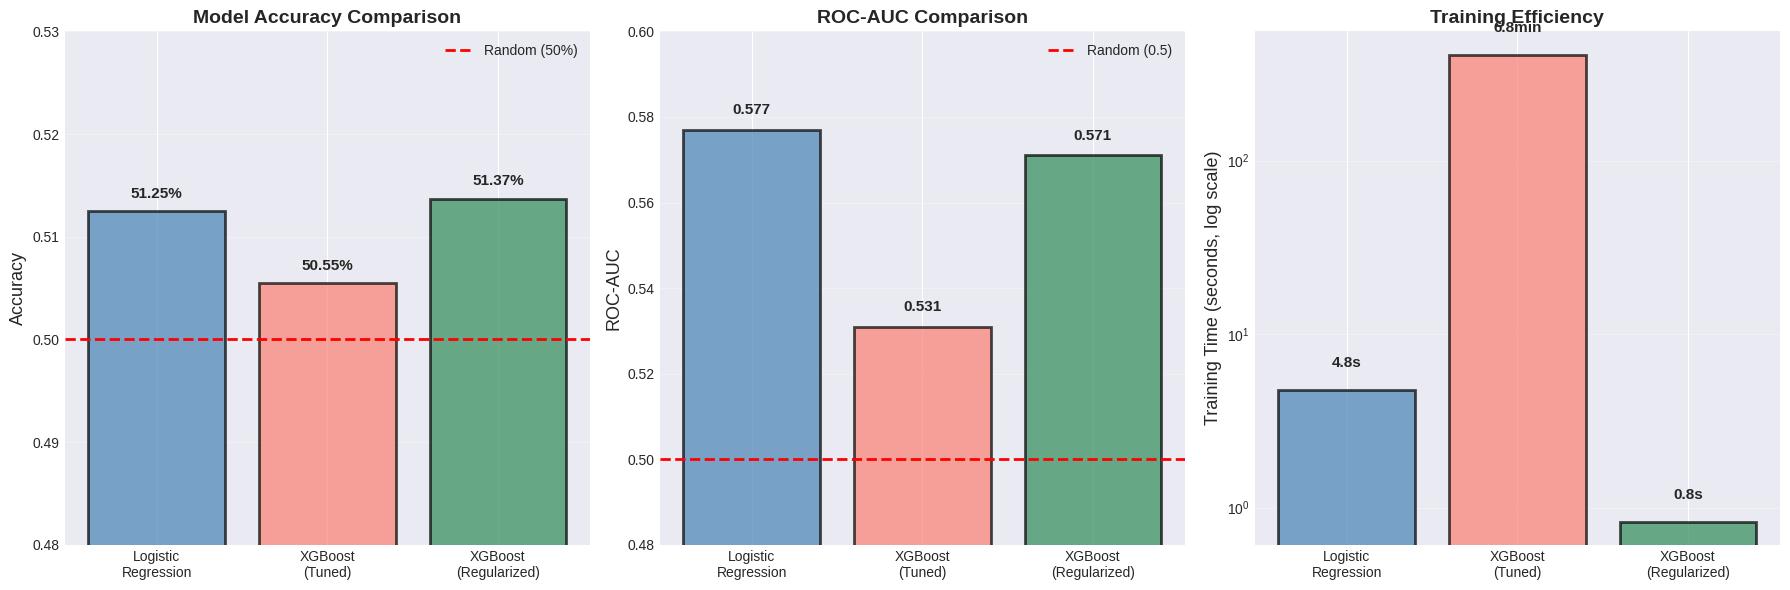

✓ Final comparison saved as 'model_comparison_final.png'


In [15]:
print("\n" + "="*80)
print("FINAL VISUALIZATION: Model Comparison")
print("="*80)

# Create comparison plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Accuracy comparison
models = ['Logistic\nRegression', 'XGBoost\n(Tuned)', 'XGBoost\n(Regularized)']
accuracies = [0.5125, 0.5055, 0.5137]
colors = ['steelblue', 'salmon', 'seagreen']

bars = axes[0].bar(models, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[0].axhline(y=0.50, color='red', linestyle='--', label='Random (50%)', linewidth=2)
axes[0].set_ylabel('Accuracy', fontsize=13)
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim([0.48, 0.53])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{acc*100:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. ROC-AUC comparison
aucs = [0.577, 0.531, 0.571]
bars2 = axes[1].bar(models, aucs, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[1].axhline(y=0.50, color='red', linestyle='--', label='Random (0.5)', linewidth=2)
axes[1].set_ylabel('ROC-AUC', fontsize=13)
axes[1].set_title('ROC-AUC Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylim([0.48, 0.60])
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

for bar, auc in zip(bars2, aucs):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.003,
                f'{auc:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 3. Training time comparison (log scale)
times = [4.77, 407.88, 0.83]
bars3 = axes[2].bar(models, times, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[2].set_ylabel('Training Time (seconds, log scale)', fontsize=13)
axes[2].set_title('Training Efficiency', fontsize=14, fontweight='bold')
axes[2].set_yscale('log')
axes[2].grid(axis='y', alpha=0.3)

for bar, t in zip(bars3, times):
    height = bar.get_height()
    label = f'{t:.1f}s' if t < 60 else f'{t/60:.1f}min'
    axes[2].text(bar.get_x() + bar.get_width()/2., height * 1.3,
                label, ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison_final.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Final comparison saved as 'model_comparison_final.png'")